## Analysis on Dual Thresholds based on the Best Distribution for Each Gene

### Author: Deb Debnath

### Motivation

As part of a discussion with Dr. Sninsky, it could be viable to set two thresholds instead of one for determining prognosis based on the classifier predictions.
The new thresholds are
1. 85% probability of Alzheimer's, i.e. probability score = 0.85
2. 85% probability of being NCI (non-cognitively impaired), i.e score = 0.15

Interpretation of this classification scheme would be
1. **High probability of AD category (Probably AD)** - Seek timely professional medical care for therapy including more aggressive hypertension, diabetes type 2 and obesity therapies as well as amyloid monoclonal antibodies
2. **Intermediate category (Intermediate)** - Self-guided comorbidity risk care (e.g. hypertension, T2 diabetes and obesity), exercise, hearing aids, cognitive engagement with testing in 6 months
3. **High probability of NCI category (Probably NCI)** - Testing in 6 months

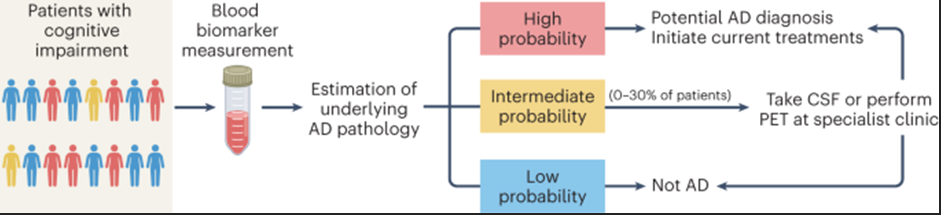

Reference table from _Wimo et al (2014)_
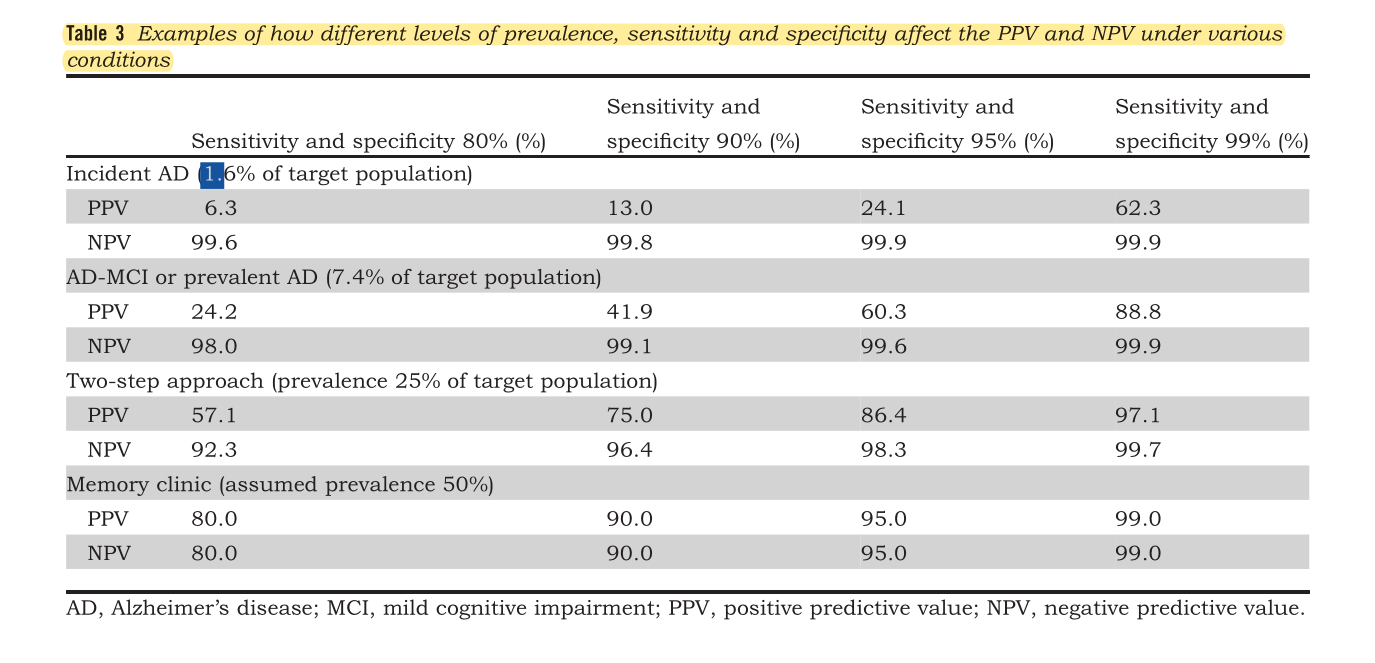

#### Data loading

In [1]:
import warnings
import logging
from dataclasses import dataclass, field
from typing import Optional, Sequence

logging.basicConfig(format="%(asctime)s-%(levelname)s: %(msg)s", level=logging.WARNING)

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot
from src.classifier import z_score, linear_classifier_score, linear_classifier_subscores, antilogit_classifier_score
from src.dist_fitting import (
        test_gamma_fit, 
        test_lognormal_fit_ks, 
        test_lognormal_fit_sw, 
        test_negative_binomial_fit, 
        test_poisson_fit, 
        test_zero_inflated_poisson_fit,
        test_zero_inflated_negative_binomial_fit
)
from src.random_sample import (
    sample_zero_inflated_poisson,
    sample_zero_inflated_negative_binomial,
    sample_poisson_mean_rsd,
    sample_zero_inflated_poisson_mean_rsd,
    sample_negative_binomial_mean_rsd,
    sample_zero_inflated_negative_binomial_mean_rsd,
    sample_gamma_mean_rsd,
    sample_lognormal_mean_rsd
)
from src.postprocessing import (
    plot_confusion_matrix,
    display_differential_classification_results_one_threshold,
    display_differential_classification_results_two_thresholds,
    calculate_sens_spec_dual_threshold,
    calculate_subject_wise_agreement,
    calculate_subject_wise_disagreement
)

In [4]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [5]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [6]:
mean_TPM = 10

In [7]:
num_patients = 243
n_samples = 1000
uncertainties = [10, 25, 50]

In [8]:
thres_1, thres_2 = 0.15, 0.85

In [9]:
seed = 321

In [10]:
np.random.seed(seed)

#### Data preprocessing

In [11]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [12]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [13]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_355658/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [14]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [15]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [16]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [17]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [18]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [19]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [20]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

#### Figures

- V-plot
- Cluster plot

## Simulating with the Best fit Probability Distribution for each Gene

From discussions it is suggested that TPM counts for each individual gene follow a negative binomial distribution, characterized by

$$
f(k; r, p) \equiv P(X = k) = \binom{k+r-1}{k} (1-p)^{k} p^{k}
$$

where

- $r$ > 0 — number of successes until the experiment is stopped (integer)
- $p$ ∈ $[0,1]$ — success probability in each experiment (real)

From Sam's email:

&nbsp;&nbsp;&nbsp;&nbsp;In regards to gene distributions from the Science Advances dataset, a quick analysis revealed:

- Negative Binomial Distribution: The computational analysis (run in a Jupyter Python notebook) confirmed the majority of the genes in this TPM RNA-Seq dataset fit a negative binomial distribution. This is supported by the p-value threshold of 0.10 applied in the Kolmogorov-Smirnov test.  Approximately 61% of genes in the AD dataset and 77% in the NCI dataset fit this distribution. This provides strong evidence that the negative binomial model is appropriate for modelling the variability in the RNA-Seq data. 

- Negative Binomial Distribution ~ Details on Process, already shared with JS:
    The process looks something like this:
  - We use the Kolmogorov-Smirnov Test to compare the empirical distribution of the data with the theoretical distribution (in this case, we nominate the negative binomial distribution).
  - We calculate a p-value which tells us the probability that the observed data could come from the theoretical distribution.
  - In the code, we set the p-value threshold at 0.10. We interpret it like so; if the p-value is greater than 0.10, it means the gene's expression values do not significantly differ from a negative binomial distribution. Thus, we consider the gene to fit the negative binomial distribution. Conversely, if the p-value is less than or equal to 0.10, it means the gene's expression values do significantly differ from the negative binomial distribution, and we consider the gene to not fit the negative binomial distribution.
  - We have provided the html output for reference, listing the p-values; a boolean of whether neg binomial or not;TPM mean;TPM median. Then we calculate the percentage and count of genes that fit the negative binomial distribution per pathology.  Would you like to look at this now from the perspective of setting a TPM threshold to investigate whether there is a relationship between high/low TPM and distribution type?
  - For quick reference: NCI - Percentage of genes in df_NCI that fit the negative binomial distribution: 77.75%. NCI - Count of genes in df_NCI that fit the negative binomial distribution: 720. AD - Percentage of genes in df_AD that fit the negative binomial distribution: 61.02%. AD - Count of genes in df_AD that fit the negative binomial distribution: 565.
  - Also attached are 2 pdf's (AD and NCI) of all gene distributions as a reference of sorts (raw data plots).
  - Please note a TPM mean of 3 filtered the original dataframe.
- High or low TPM associations with distribution type:
  - AD Dataset:
    - Genes with mean TPM ≤ 10 that are negative binomial: 84
    - Genes with mean TPM ≥ 10 that are negative binomial: 481
    - Genes with mean TPM ≤ 10 that are not negative binomial: 194
    - Genes with mean TPM ≥ 10 that are not negative binomial: 167
  - NCI Dataset:
    - Genes with mean TPM ≤ 10 that are negative binomial: 146
    - Genes with mean TPM ≥ 10 that are negative binomial: 574
    - Genes with mean TPM ≤ 10 that are not negative binomial: 117
    - Genes with mean TPM ≥ 10 that are not negative binomial: 89
- Other Distributions for AD Dataset: Among the genes that did not fit the negative binomial distribution, the following distributions were identified:
  - Normal Distribution: 90 genes
  - Exponential Distribution: 142 genes
  - Gamma Distribution: 156 genes
  - Log-Normal Distribution: 104 genes
  - Poisson Distribution: 0 genes
  - None*: 75 genes
- Other Distributions for NCI Dataset: Among the genes that did not fit the negative binomial distribution, the following distributions were identified:
  - Normal Distribution: 175 genes
  - Exponential Distribution: 177 genes
  - Gamma Distribution: 110 genes
  - Log-Normal Distribution: 39 genes
  - Poisson Distribution: 0 genes
  - None*: 66 genes

Following up with a first pass on the concordance/discordance data:

- The concordant/discordant distribution rate across 926 genes show the following between AD and NCI :

    - No of Concordant Negative Binomial Distribution: 506
    - No of Concordant Non-Negative Binomial Distribution: 147
    - No of Discordant Non-Negative Binomial in AD and Neg Binomial in NCI : 214
    - No of Discordant Negative Binomial in AD and Non-Negative Binomial in NCI : 59

- Of those genes above, when the next set of distributions were tested (i.e those which are not negative binomial (n=331)) this is the concordant/discordant breakdown. It does not include those in the 'none' category of distributions:

    - No of Concordant Distributions between AD and NCI: 135
    - No of Discordant Distributions between AD and NCI: 196


From the information provided above, 506 genes, or > 50% of the genes in both AD and NCI datasets conform to the negative binomial distribution. On the basis of this finding, we have the following options in modeling the uncertainty of genes
1. fit the negative binomial distribution to all genes.
2. fit each gene to its own (suggested) distribution.

Additionally, to simulate measurement uncertainty with a given degree, we can use $\mu =X$ and $\sigma = 0.1 X$, calculating the parameters for the negative binomial distribution ($r, p$) from $\mu$ and $\sigma$ as

$$
r = \frac{\mu^2}{\sigma^{2}-\mu}, \\
p = \frac{\mu}{\sigma^2}
$$

Possible approaches to model uncertainty (Sam):
1. Use the Full Unfiltered Data Matrix with Only Rounding: Start with the unfiltered df2_t, keeping raw TPM values and apply only rounding, so no transformations or filtering. TPM data combines biological and technical variability, resulting in large variances (e.g., 8391.04 for ENSG00000079482.12), and preserving these ensures the classifier, trained on this full range including low-expression genes, is tested against realistic variability.
    
2. Fit a Distribution to Each Gene’s TPM Values: Analyze the ~234 TPM values per gene in the unfiltered df2_t to determine its best-fitting distribution, such as negative binomial, log-normal, or gamma etc. The added noise thus mimics the gene’s natural variability pattern. This ensures the noise challenges the classifier’s probability estimates by reflecting each gene’s unique behavior, like the overdispersion seen in VMR results (e.g., 140.4 for ENSG00000079482.12).

3. Run the separate simulations with 10%, 20%, and 50% noise levels: Set the three noise levels (we should also consider adding 30%), and run the separate Monte Carlo simulations to generate new TPM values that flip the classifier predictions. We need to explore two options: 
    a) per-gene, sampling all ~234 values in a gene’s column from a distribution set by its average TPM (e.g., 59.77 for ENSG00000079482.12), or 
    b) per-cell, sampling each patient’s TPM  from a distribution scaled to that value, adjusted for larger shifts if needed. 
    
I have been mulling whether (a) or (b) best captures variability and precision. For approach (a) it’s like a single cookie cutter approach for the whole group where everyone’s new TPM count will be based on the group average, not their own starting point. This worries me as it does meet the per-analyte precision test requirements but misses the "different combinations" simulation depth as requested by the FDA. For (b) it is a more specific approach for each subject's TPM. It’s more work, but it keeps the starting TPM in mind, making the changes more unique to the subject. Note, that we still need to test the distribution in principle 2 e.g., log-normal as it is used in both a and b, rather just applied differently.

## How do we add noise for a given distribution?

We are provided with the % uncertainty we want to simulate using noise, say $k$ ($0 \le k \le 1$), such that for a measurement $X$, the mean is $X$ and standard deviation is $kX$.

## Discrete distributions

#### 1. Poisson distribution

For a Poisson distribution the relative uncertainty (i.e. the standard deviation divided by the mean) is

$$
\frac{\sigma}{\mu} = \frac{\sqrt{\lambda}}{\lambda} = \frac{1}{\sqrt{\lambda}}.
$$

So if we want a relative uncertainty of $k$, we need

$$
\frac{1}{\sqrt{\lambda}} = k \quad \Longrightarrow \quad \lambda = \frac{1}{k^2}.
$$

To achieve this we sample from a Poisson distribution with $\lambda = \frac{1}{k^2}$.  Then we scale each value by $\frac{X}{1/k^2} = Xk^2$ so that the final samples have a mean $X$ and standard deviation $kX$.

#### 2. Negative binomial distribution

For a negative binomial distribution $NB(r, p)$ parametrized by $r$ (number of successes until the experiment is stopped) and $p$ (success probability in each experiment), mean $\mu$ and standard deviation $\sigma$ are given by

$$
\mu = \frac{r(1-p)}{p}
$$

$$
\sigma = \frac{\sqrt{r(1-p)}}{p}
$$

So, we need

$$
X = \frac{r(1-p)}{p}
$$

$$
kX = \frac{\sqrt{r(1-p)}}{p}
$$

When we solve these two equations for $r$ and $p$, we get

$$
p = \frac{1}{Xk^2} 
$$

$$
r = \frac{1}{(1-p)}{k^2}
$$

Because $0 \le p \le 1$, we must have

$$
k^2 > \frac{1}{X}.
$$

In other words, the desired relative uncertainty $k$ must be at least as large as the Poisson limit $1/\sqrt{X}$. (For instance, if $X=50$, then $1/\sqrt{50}\approx 14\%$; we cannot model a 10% relative uncertainty with a negative binomial when the “baseline” Poisson uncertainty is 14%.)  



#### 3. Zero-inflated Poisson distribution (ZIP)

For a ZIP model, the probability mass function is

$$
P(Y=0) = \pi + (1-\pi)e^{-\lambda},\quad P(Y=y) = (1-\pi)e^{-\lambda}\frac{\lambda^y}{y!}\quad \text{for } y\ge1.
$$

where $\pi$ is the probability threshold below which a random sample is a zero.

Its mean $\mu$ and standard deviation $\sigma$ are

$$
\mu = (1-\pi)\lambda
$$

$$
\sigma = \sqrt{\lambda(1-\pi)(1+\pi\lambda)}
$$

If we want $\mu = X$ and $\sigma = kX$, we have

$$
X = (1-\pi)\lambda
$$

$$
kX = \sqrt{\lambda(1-\pi)(1+\pi\lambda)}
$$

Solving for $\pi$ and $\lambda$ gives

$$
\pi = \frac{1}{1+\frac{1}{k^2-1/\mu}}
$$

$$
\lambda = \frac{X}{1-\pi}
$$

Here as well, as $0 \le \pi \le 1$, we need $Xk^2 > 1$. 

[Source](https://en.wikipedia.org/wiki/Zero-inflated_model)

#### 4. Zero inflated Negative Binomial (ZINB) distribution

We use a similar parametrization as the negative binomial distribution above with the added parameter of $\pi$. Since this time $\pi$ can be set independently of $X$ and $k$ we can simply set

$$
p = \frac{1}{Xk^2} 
$$

$$
r = \frac{1}{(1-p)}{k^2}
$$

Because $0 \le p \le 1$, we must have

$$
k^2 > \frac{1}{X}.
$$

## Continuous distributions

### 1. Normal distribution

TBD

### 2. Log-normal distribution

TBD

### 3. Gamma distribution

TBD

## Goodness of fit criteria

### 1. Kolmogorov–Smirnov (KS) Test

The KS test measures the maximum distance between the empirical CDF of the data and the CDF of the fitted model. A high p-value suggests that the model is a good fit (i.e. there is no significant difference).

### 2. Anderson–Darling (AD) Test

The AD test is similar in spirit to the KS test but gives extra weight to the tails of the distribution. 

### 3. Akaike Information Criterion (AIC)

## Experiments

#### Loading in prior study from Sam

In [21]:
neg_binom_test_data_ad = pd.read_excel("../../../code/dist_fitting/negative_binomial_test_data.xlsx", sheet_name=0, index_col=0)
neg_binom_test_data_nci = pd.read_excel("../../../code/dist_fitting/negative_binomial_test_data.xlsx", sheet_name=1, index_col=0)

## Fitting discrete distributions to Gene data

In [22]:
warnings.filterwarnings("ignore")
def find_best_dist_aic(gene: str, results: pd.DataFrame) -> str:
    subset = results.loc[gene, ["poisson_aic", "nb_aic", "zip_aic", "zinb_aic"]]
    subset = subset.dropna()
    min_aic = subset.min()
    filt = (subset == min_aic)
    return subset[filt].index[0].split("_")[0].upper()

def find_best_dist_ks_p_value(gene: str, results: pd.DataFrame) -> Optional[str]:
    subset = results.loc[gene, ["poisson_p_val", "nb_p_val", "zip_p_val", "zinb_p_val"]]
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= 0.05]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].split("_")[0].upper()

def fit_discrete_distributions_to_genes(tpm_df: pd.DataFrame, means: pd.Series, stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=tpm_df.index, columns=["vmr", "best_fit_aic", "best_fit_p_value",
                                                      "poisson_aic", "poisson_ks_stat", "poisson_p_val", "poisson_lambda", 
                                                      "nb_aic", "nb_ks_stat", "nb_p_val", "nb_r", "nb_p", 
                                                      "zip_aic", "zip_ks_stat", "zip_p_val", "zip_lambda", "zip_pi",
                                                      "zinb_aic", "zinb_ks_stat", "zinb_p_val", "zinb_r", "zinb_p", "zinb_pi"])
    for i in range(tpm_df.shape[0]):
        gene = tpm_df.index[i]
        row = tpm_df.iloc[i, :]
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, ["poisson_aic", "poisson_ks_stat", "poisson_p_val", "poisson_lambda"]] = test_poisson_fit(row)
        res.loc[gene, ["zip_aic", "zip_ks_stat", "zip_p_val", "zip_lambda", "zip_pi"]] = test_zero_inflated_poisson_fit(row)
        res.loc[gene, ["nb_aic", "nb_ks_stat", "nb_p_val", "nb_r", "nb_p"]] = test_negative_binomial_fit(row)
        res.loc[gene, ["zinb_aic", "zinb_ks_stat", "zinb_p_val", "zinb_r", "zinb_p", "zinb_pi"]] = test_zero_inflated_negative_binomial_fit(row)
        res.loc[gene, "best_fit_aic"] = find_best_dist_aic(gene, res)
        res.loc[gene, "best_fit_p_value"] = find_best_dist_ks_p_value(gene, res)
    return res

In [23]:
discrete_dist_fitting_results = fit_discrete_distributions_to_genes(patients_df, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion')

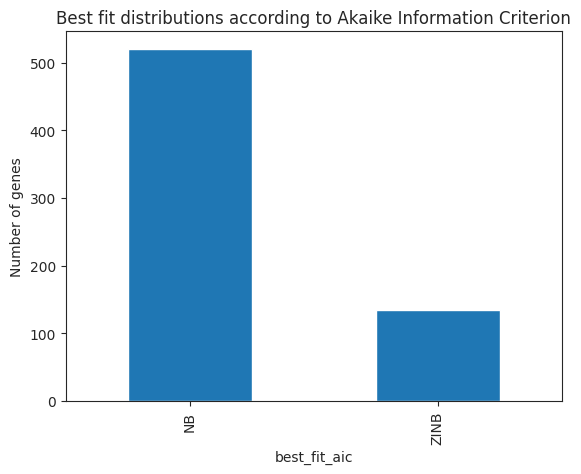

In [24]:
vc = discrete_dist_fitting_results["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic')

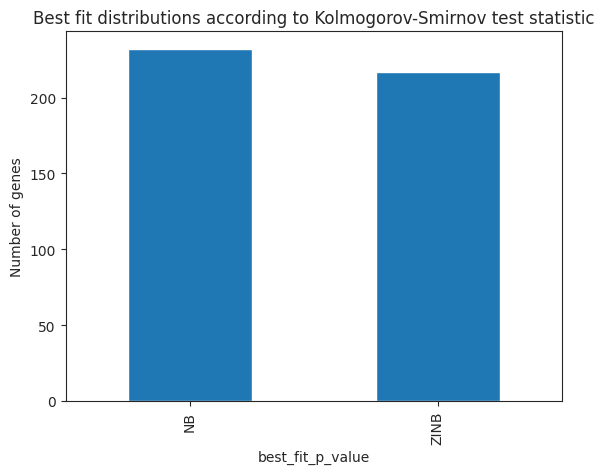

In [25]:
vc = discrete_dist_fitting_results["best_fit_p_value"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic")

## Fitting continuous distributions to Gene data

In [26]:
def find_best_continuous_dist_p_value(gene: str, results: pd.DataFrame) -> Optional[str]:
    subset = results.loc[gene, ["gamma_ks_p_val", "lognormal_sw_p_val"]]
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= 0.05]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].split("_")[0].upper()

def fit_continuous_distributions_to_genes(tpm_df: pd.DataFrame, means: pd.Series, stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=tpm_df.index, columns=["vmr", "best_fit", "best_fit_ad", "best_fit_nci",
                                                                 "gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta", 
                                                                 "lognormal_sw_stat", "lognormal_sw_p_val"])
    for i in range(tpm_df.shape[0]):
        gene = tpm_df.index[i]
        row = tpm_df.iloc[i, :]
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, ["gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta"]] = test_gamma_fit(row)
        res.loc[gene, ["lognormal_sw_stat", "lognormal_sw_p_val"]] = test_lognormal_fit_sw(row)
        res.loc[gene, "best_fit"] = find_best_continuous_dist_p_value(gene, res)
    return res

In [27]:
continuous_dist_fitting_results = fit_continuous_distributions_to_genes(patients_df, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values')

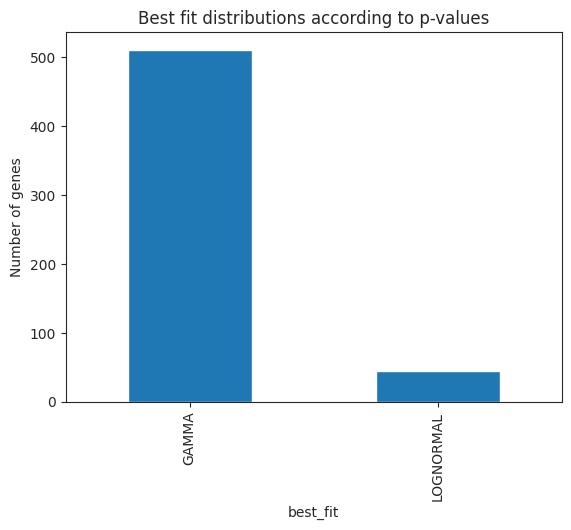

In [28]:
vc = continuous_dist_fitting_results["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values")

## Are fitted distributions concordant across pathologies?

### Prep

In [29]:
nci_filt = (pathos == "NCI")

In [30]:
nci_subset = patients_df.loc[:, pathos[nci_filt.values].index]
ad_subset = patients_df.loc[:, pathos[~nci_filt.values].index]

### Discrete distributions

#### AD

In [31]:
discrete_dist_fitting_results_ad = fit_discrete_distributions_to_genes(ad_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion (AD subset)')

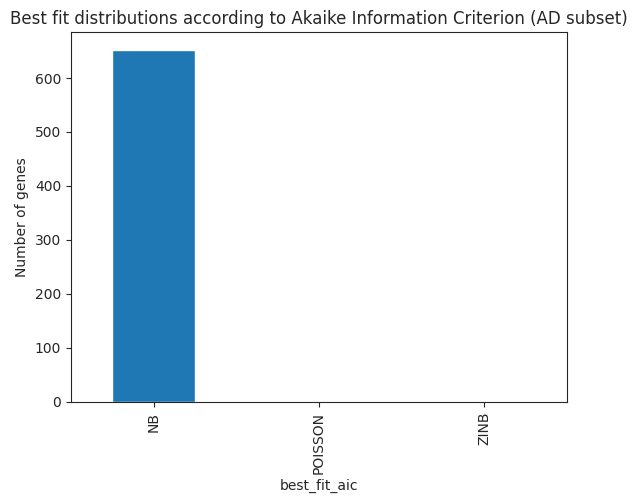

In [32]:
vc = discrete_dist_fitting_results_ad["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion (AD subset)")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic (AD subset)')

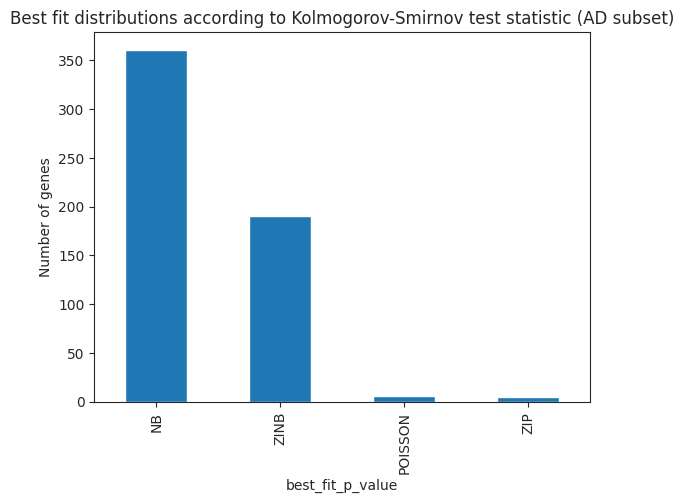

In [33]:
vc = discrete_dist_fitting_results_ad["best_fit_p_value"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic (AD subset)")

#### NCI

In [34]:
discrete_dist_fitting_results_nci = fit_discrete_distributions_to_genes(nci_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion (NCI subset)')

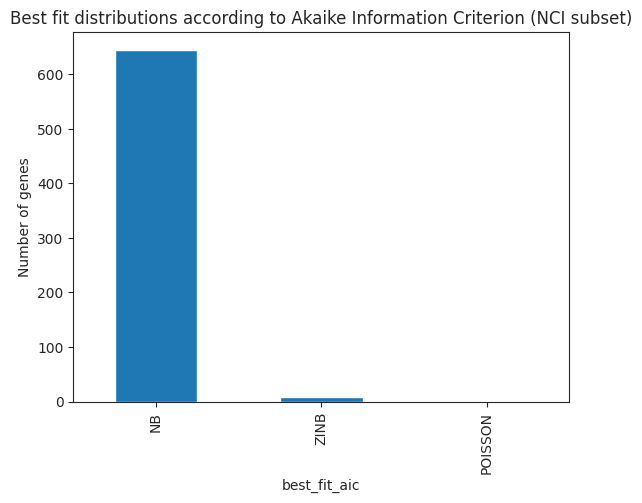

In [35]:
vc = discrete_dist_fitting_results_nci["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion (NCI subset)")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic (NCI subset)')

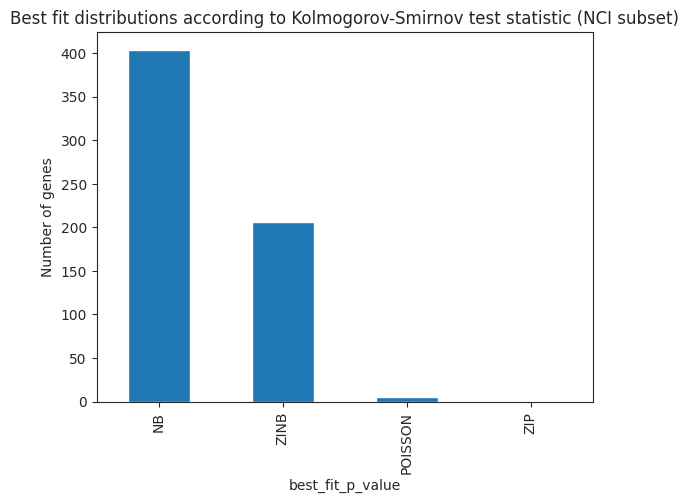

In [36]:
vc = discrete_dist_fitting_results_nci["best_fit_p_value"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic (NCI subset)")

#### Concordance between AD and NCI

In [37]:
discrete_dist_wise_concordance = pd.DataFrame(index=["poisson", "nb", "zip", "zinb"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in discrete_dist_wise_concordance.index:
    col = f"{dist}_p_val"
    ad_filt = (discrete_dist_fitting_results_ad[col] >= 0.05)
    nci_filt = (discrete_dist_fitting_results_nci[col] >= 0.05)
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    discrete_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    discrete_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
discrete_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
poisson,5,20
nb,529,112
zip,5,20
zinb,352,234


In [38]:
discrete_dist_wise_concordance = pd.DataFrame(index=["POISSON", "NB", "ZIP", "ZINB"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in ["POISSON", "NB", "ZIP", "ZINB"]:
    ad_filt = (discrete_dist_fitting_results_ad["best_fit_aic"] == dist)
    nci_filt = (discrete_dist_fitting_results_nci["best_fit_aic"] == dist)
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    discrete_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    discrete_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
discrete_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
POISSON,0,3
NB,642,13
ZIP,0,0
ZINB,0,10


In [39]:
discrete_dist_wise_concordance = pd.DataFrame(index=["POISSON", "NB", "ZIP", "ZINB"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in ["POISSON", "NB", "ZIP", "ZINB"]:
    ad_filt = discrete_dist_fitting_results_ad["best_fit_p_value"] == dist
    nci_filt = discrete_dist_fitting_results_nci["best_fit_p_value"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    discrete_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    discrete_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
discrete_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
POISSON,1,9
NB,237,291
ZIP,0,6
ZINB,69,258


### Continuous distributions

#### AD

In [40]:
continuous_dist_fitting_results_ad = pd.DataFrame(index=patients_df.index, columns=["vmr", "best_fit", "best_fit_ad", "best_fit_nci",
                                                                 "gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta", 
                                                                 "lognormal_sw_stat", "lognormal_sw_p_val"])

In [41]:
continuous_dist_fitting_results_ad = fit_continuous_distributions_to_genes(ad_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values (AD subset)')

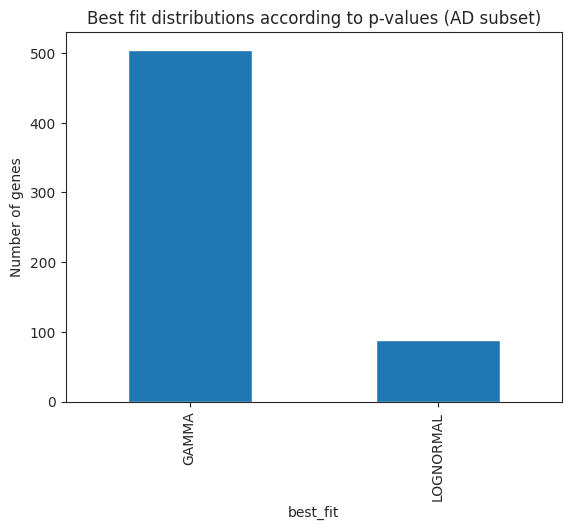

In [42]:
vc = continuous_dist_fitting_results_ad["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values (AD subset)")

<Axes: ylabel='ENSG00000079482.12'>

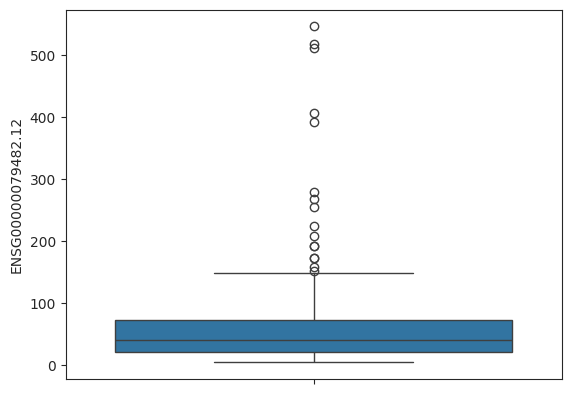

In [71]:
sns.boxplot(data=ad_subset.T, y=ad_subset.index[0])

<Axes: ylabel='ENSG00000079482.12'>

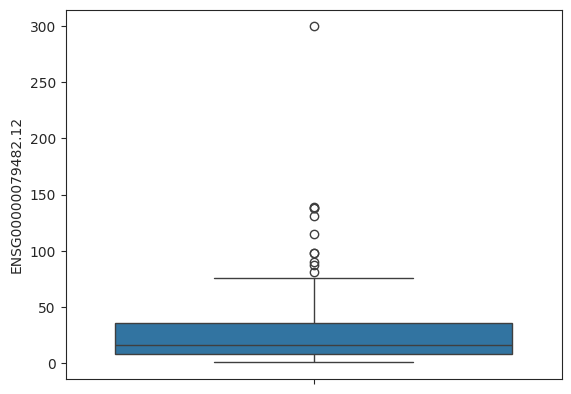

In [72]:
sns.boxplot(data=nci_subset.T, y=nci_subset.index[0])

#### NCI

In [43]:
continuous_dist_fitting_results_nci = fit_continuous_distributions_to_genes(nci_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values (NCI subset)')

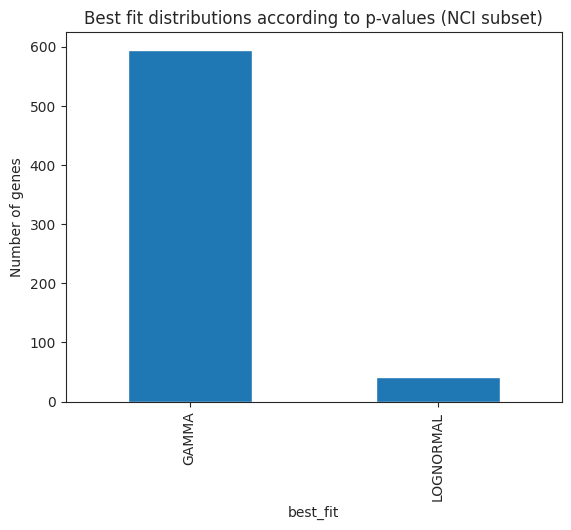

In [44]:
vc = continuous_dist_fitting_results_nci["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values (NCI subset)")

#### Concordance between AD and NCI

In [45]:
continuous_dist_wise_concordance = pd.DataFrame(index=["lognormal", "gamma"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in continuous_dist_wise_concordance.index:
    col = "lognormal_sw_p_val" if dist == "lognormal" else "gamma_ks_p_val"
    ad_filt = (continuous_dist_fitting_results_ad[col] >= 0.05)
    nci_filt = (continuous_dist_fitting_results_nci[col] >= 0.05)
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    continuous_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    continuous_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes)) 
continuous_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
lognormal,91,273
gamma,560,91


In [46]:
continuous_dist_wise_concordance = pd.DataFrame(index=["LOGNORMAL", "GAMMA"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in ["LOGNORMAL", "GAMMA"]:
    ad_filt = continuous_dist_fitting_results_ad["best_fit"] == dist
    nci_filt = continuous_dist_fitting_results_nci["best_fit"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    continuous_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    continuous_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes)) 
continuous_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
LOGNORMAL,14,102
GAMMA,471,158


### Checking for concordance by considering only Negative binomial, lognormal and gamma distributions

For comparing between the three, distribution-specific goodness of fit metrics are used - 
- p-value for the KS test for negative binomial and gamma distributions
- p-value for the Shapiro-Wilk test for the lognormal distribution.

#### Overall

In [47]:
def _find_best_dist(lognormal_sw_p_val: Optional[float], gamma_ks_p_val: Optional[float], nb_ks_p_val: Optional[float]) -> Optional[str]:
    subset = pd.Series(index=["lognormal", "negative binomial", "gamma"], data=[lognormal_sw_p_val, gamma_ks_p_val, nb_ks_p_val])
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= 0.05]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].upper()


def find_best_fit_dist(*, 
                       lognormal_sw_p_vals: pd.Series, 
                       gamma_ks_p_vals: pd.Series,
                       nb_ks_p_vals: pd.Series,
                       means: pd.Series, 
                       stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=lognormal_sw_p_vals.index, columns=["vmr", "best_fit", "gamma_ks_p_val", "lognormal_sw_p_val", "nb_ks_p_val"])
    for gene in res.index:
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, "best_fit"] = _find_best_dist(lognormal_sw_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene])
        res.loc[gene, ["lognormal_sw_p_val", "gamma_ks_p_val", "nb_ks_p_val"]] = lognormal_sw_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene]
    return res

In [48]:
dist_fitting_results = find_best_fit_dist(lognormal_sw_p_vals=continuous_dist_fitting_results["lognormal_sw_p_val"],
                                            gamma_ks_p_vals=continuous_dist_fitting_results["gamma_ks_p_val"],
                                            nb_ks_p_vals=discrete_dist_fitting_results["nb_p_val"], 
                                            means=means, stds=stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values')

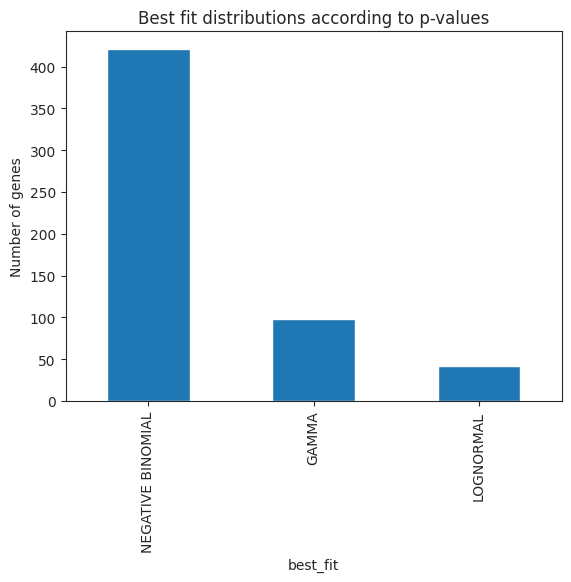

In [49]:
vc = dist_fitting_results["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values")

#### AD and NCI

In [50]:
dist_fitting_results_ad = find_best_fit_dist(lognormal_sw_p_vals=continuous_dist_fitting_results_ad["lognormal_sw_p_val"],
                                            gamma_ks_p_vals=continuous_dist_fitting_results_ad["gamma_ks_p_val"],
                                            nb_ks_p_vals=discrete_dist_fitting_results_ad["nb_p_val"], 
                                            means=means, stds=stds)

In [51]:
dist_fitting_results_nci = find_best_fit_dist(lognormal_sw_p_vals=continuous_dist_fitting_results_nci["lognormal_sw_p_val"],
                                            gamma_ks_p_vals=continuous_dist_fitting_results_nci["gamma_ks_p_val"],
                                            nb_ks_p_vals=discrete_dist_fitting_results_nci["nb_p_val"], 
                                            means=means, stds=stds)

In [59]:
vc = dist_fitting_results["best_fit"].value_counts()
vc_ad = dist_fitting_results_ad["best_fit"].value_counts()
vc_nci = dist_fitting_results_nci["best_fit"].value_counts()

In [60]:
width = 0.3

Text(0.5, 1.0, 'Best fit distributions according to p-values')

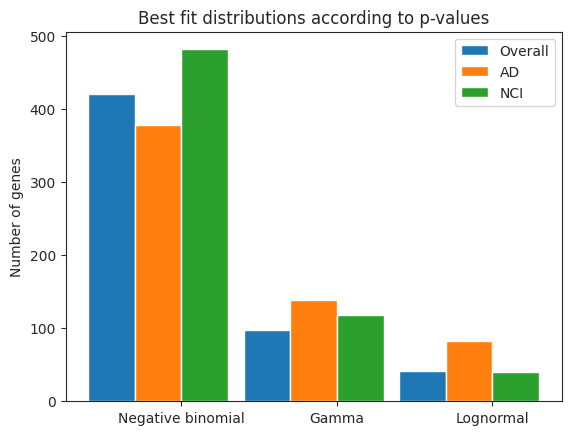

In [65]:
plt.bar(np.arange(3), vc, width, label="Overall")
plt.bar(np.arange(3)+width, vc_ad, width, label="AD")
plt.bar(np.arange(3)+2*width, vc_nci, width, label="NCI")
plt.xticks(np.arange(3)+1.5*width, ["Negative binomial", "Gamma", "Lognormal"])
plt.ylabel("Number of genes")
plt.legend()
plt.title("Best fit distributions according to p-values")

In [52]:
dist_wise_concordance = pd.DataFrame(index=["NEGATIVE BINOMIAL", "GAMMA", "LOGNORMAL"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in dist_wise_concordance.index:
    ad_filt = dist_fitting_results_ad["best_fit"] == dist
    nci_filt = dist_fitting_results_nci["best_fit"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
dist_wise_concordance

,Number of concordant genes,Number of discordant genes
NEGATIVE BINOMIAL,323,214
GAMMA,47,162
LOGNORMAL,13,96


In [53]:
print(dist_fitting_results["best_fit"].isna().sum(), dist_fitting_results_ad["best_fit"].isna().sum(), dist_fitting_results_nci["best_fit"].isna().sum())

94 57 15


## Sampling from Best Fit Distributions (Subject level)

### Testing

In [104]:
i, j = np.random.randint(0, patients_df.shape[0]), np.random.randint(0, patients_df.shape[1])

In [112]:
def plot_boxplot_gene_samples(patients_df: pd.DataFrame, uncertainty: int, n_samples: int, i: int, j: int):
    gene = patients_df.index[i]
    mean = patients_df.iloc[i, j] 
      
    # Sample from distribution
    if (uncertainty / 100) ** 2.0 > 1/mean:
        samples_nb = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
    else:
        samples_nb = None
    samples_ln = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
    samples_g = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)

    # Plot boxplots of genes
    data, labels = [samples_ln, samples_g], ["lognormal", "gamma"]
    if samples_nb is not None:
        data.append(samples_nb)
        labels.append("negative binomial")
    plt.figure()
    plt.boxplot(data)
    plt.xticks(list(range(1, len(labels)+1)), labels)
    plt.ylabel("Simulated TPM counts")
    plt.title(f"{gene=}, mean = {mean:.2f}, uncertainty = {uncertainty}%")

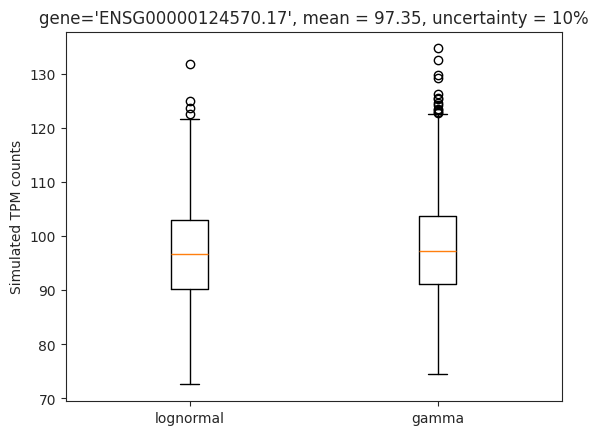

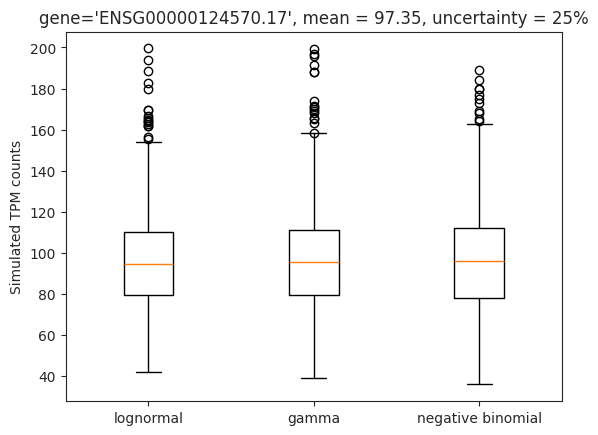

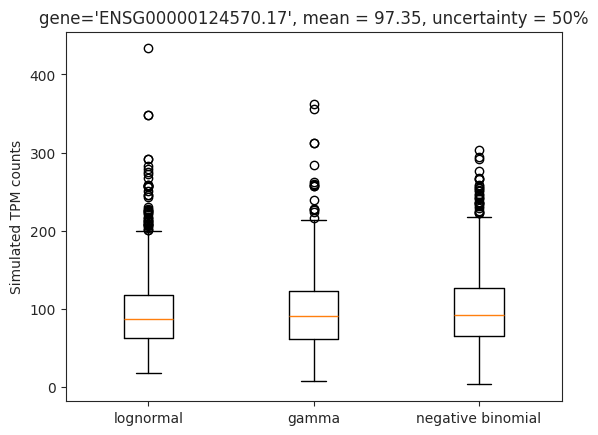

In [113]:
plot_boxplot_gene_samples(patients_df, 10, n_samples, i, j)
plot_boxplot_gene_samples(patients_df, 25, n_samples, i, j)
plot_boxplot_gene_samples(patients_df, 50, n_samples, i, j)

### Sampling

In [50]:
@dataclass
class SingleThresholdResults:
    gt_list: list[np.ndarray] = field(default_factory=list)
    preds_list: list[np.ndarray] = field(default_factory=list)
    ad_diff_cls: int = 0
    nci_diff_cls: int = 0    
    
@dataclass
class DualThresholdResults:
    gt_list: list[np.ndarray] = field(default_factory=list)
    preds_list: list[np.ndarray] = field(default_factory=list)
    ad_diff_cls: int = 0
    int_diff_cls: int = 0
    nci_diff_cls: int = 0

In [51]:
def simulate_sampling_experiment(
            z_scores_df: pd.DataFrame, 
            *,
            dual_thres_1: float, 
            dual_thres_2: float,
            single_thres: float,
            diff_class_lim: int,
            uncertainty: float,
            n_samples: int,
            coefficients: np.ndarray | pd.Series, 
            continuous_dist_fitting_results: pd.DataFrame,
            num_patients: int = 243,
            n_features: int = 967
    ) -> tuple[SingleThresholdResults, DualThresholdResults, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform simulation experiments for single and dual thresholds, return the predicted and ground truth classes 
    and number of differentially classified individuals for each class, along with all predicted linear scores and probabilities.
    """
    if not 0 <= dual_thres_1 <= 1 and 0 <= dual_thres_2 <= 1 and 0 <= single_thres <= 1:
        raise ValueError("Thresholds should be between 0 and 1.")
    if dual_thres_1 == dual_thres_2:
        raise ValueError("Thresholds for two threshold simulations should be distinct.")
    if not 1 <= diff_class_lim <= n_samples:
        raise ValueError(f"The limit for differential classification should be between 1 and {n_samples}.")
    pred_linear_scores = []
    pred_probs = []
    pred_pos_subscores, pred_neg_subscores = [], []

    # Single and dual threshold result variables
    single_thres_res = SingleThresholdResults()
    dual_thres_res = DualThresholdResults()
    
    for j in range(num_patients):
        samples = np.zeros((n_features, n_samples))

        for i in range(n_features):
            gene = patients_df.index[i]
            mean = patients_df.iloc[i, j] 
            
            # Pick the best distribution for each gene based on a suitable criterion (variance to mean ratio, VMR)
            if continuous_dist_fitting_results.loc[gene, "vmr"] > 1 and (uncertainty / 100) ** 2.0 > 1/mean:
                best_dist = "NB"
            elif continuous_dist_fitting_results.loc[gene, "best_fit"]:
                best_dist = continuous_dist_fitting_results.loc[gene, "best_fit"]
            else:
                best_dist = "GAMMA"
            
            # Sample from distribution
            match best_dist:
                case "NB":
                    samples[i] = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
                case "LOGNORMAL":
                    samples[i] = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
                case "GAMMA":
                    samples[i] = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)
                # case "POISSON":
                    # samples[i] = sample_poisson_mean_rsd(mean, uncertainty / 100.0, n_samples)
                # case "ZIP":
                    # samples[i] = sample_zero_inflated_poisson_mean_rsd(mean, uncertainty / 100.0, n_samples)
                # case "ZINB":
                    # samples[i] = sample_zero_inflated_negative_binomial_mean_rsd(
                                # mean, uncertainty / 100.0, discrete_dist_fitting_results.loc[gene, "zinb_pi"], n_samples)

        # Convert sampled TPMs to z-scores
        samples = z_score(samples,  means.values[:n_features, np.newaxis], stds.values[:n_features, np.newaxis])
    
        # Get predicted probabilities from z-scores
        neg_subscores, pos_subscores = linear_classifier_subscores(coefficients[:n_features], samples)
        lin_scores = pos_subscores + neg_subscores
        probs = antilogit_classifier_score(lin_scores)

        # Keep track of linear scores, positive and negative subscores and simulated probabilities
        pred_linear_scores.append(lin_scores)
        pred_probs.append(probs)
        pred_pos_subscores.append(pos_subscores)
        pred_neg_subscores.append(neg_subscores)
    
        # Get ground truth probabilities from original TPMs
        tpm_z_scores = z_score(patients_df.iloc[:, j], means[:n_features], stds[:n_features])
        y_0 = antilogit_classifier_score(linear_classifier_score(coefficients, tpm_z_scores))

        # Single threshold calculations
        gt_label = 0 if y_0 < single_thres else 1
        
        preds = np.zeros(n_samples, dtype=np.int64)
        preds[(single_thres <= probs)] = 1 

        if np.sum(preds != gt_label) >= diff_class_lim:
            if gt_label == 0:
                single_thres_res.ad_diff_cls += 1
            else:
                single_thres_res.nci_diff_cls += 1
            
        gt_arr = np.ones(n_samples, dtype=np.int64) * gt_label
        single_thres_res.gt_list.append(gt_arr)
        single_thres_res.preds_list.append(preds)

        # Dual threshold calculations
        if y_0 < dual_thres_1:
            gt_label = 0
        elif dual_thres_1 <= y_0 < dual_thres_2:
            gt_label = 1
        else:
            gt_label = 2

        preds = np.zeros(n_samples, dtype=np.int64)
        preds[(dual_thres_1 <= probs) & (probs < dual_thres_2)] = 1 
        preds[probs >= dual_thres_2] = 2
        
        if np.sum(preds != gt_label) >= diff_class_lim:
            match gt_label:
                case 0:
                    dual_thres_res.nci_diff_cls += 1
                case 1:
                    dual_thres_res.int_diff_cls += 1
                case 2:
                    dual_thres_res.ad_diff_cls += 1
        
        gt_arr = np.ones(n_samples, dtype=np.int64) * gt_label
        dual_thres_res.gt_list.append(gt_arr)
        dual_thres_res.preds_list.append(preds)
            
    lin_scores_all = np.hstack(pred_linear_scores)
    pred_probs_all = np.hstack(pred_probs)
            
    pos_subscores_all = np.hstack(pred_pos_subscores)
    neg_subscores_all = np.hstack(pred_neg_subscores)
    return single_thres_res, dual_thres_res, neg_subscores_all, pos_subscores_all, lin_scores_all, pred_probs_all

### Simulations

In [52]:
single_thres_expt_results = pd.DataFrame(index=uncertainties, 
                                  columns=["AD", "NCI"])

In [53]:
dual_thres_expt_results = pd.DataFrame(index=uncertainties, 
                                  columns=["AD", "Intermediate", "NCI"])

In [54]:
score_stats = pd.DataFrame(index=uncertainties,
                           columns=["mean_lin", "std_lin", "mean_probs", "std_probs"])

In [55]:
pos_subscore_arrs, neg_subscore_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}
lin_score_arrs, pred_prob_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}

In [56]:
single_thres_gt_arrs, single_thres_pred_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}

In [57]:
dual_thres_gt_arrs, dual_thres_pred_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}

In [58]:
for uncertainty in uncertainties:
    single_thres_res, dual_thres_res, neg_subscores, pos_subscores, lin_scores, pred_probs = simulate_sampling_experiment(
                    z_scores_df, dual_thres_1=thres_1, dual_thres_2=thres_2, 
                    single_thres=thres_1, coefficients=coefficients, 
                    uncertainty=uncertainty, diff_class_lim=int(0.10*n_samples),
                    n_samples=n_samples, num_patients=num_patients,
                    continuous_dist_fitting_results=continuous_dist_fitting_results)
    single_thres_gt_arrs[uncertainty], single_thres_pred_arrs[uncertainty] = np.hstack(single_thres_res.gt_list), np.hstack(single_thres_res.preds_list)
    dual_thres_gt_arrs[uncertainty], dual_thres_pred_arrs[uncertainty] = np.hstack(dual_thres_res.gt_list), np.hstack(dual_thres_res.preds_list)
    lin_score_arrs[uncertainty], pred_prob_arrs[uncertainty] = lin_scores, pred_probs
    pos_subscore_arrs[uncertainty], neg_subscore_arrs[uncertainty] = pos_subscores, neg_subscores
    single_thres_expt_results.loc[uncertainty, "AD"] = single_thres_res.ad_diff_cls
    single_thres_expt_results.loc[uncertainty, "NCI"] = single_thres_res.nci_diff_cls
    dual_thres_expt_results.loc[uncertainty, "AD"] = dual_thres_res.ad_diff_cls
    dual_thres_expt_results.loc[uncertainty, "Intermediate"] = dual_thres_res.int_diff_cls
    dual_thres_expt_results.loc[uncertainty, "NCI"] = dual_thres_res.nci_diff_cls
    score_stats.loc[uncertainty, "mean_lin"] = np.mean(lin_scores)
    score_stats.loc[uncertainty, "std_lin"] = np.std(lin_scores)
    score_stats.loc[uncertainty, "mean_probs"] = np.mean(pred_probs)
    score_stats.loc[uncertainty, "std_probs"] = np.std(pred_probs)

In [59]:
single_thres_cnf_mats = {}
dual_thres_cnf_mats = {}

------------------10 % uncertainty-------------------


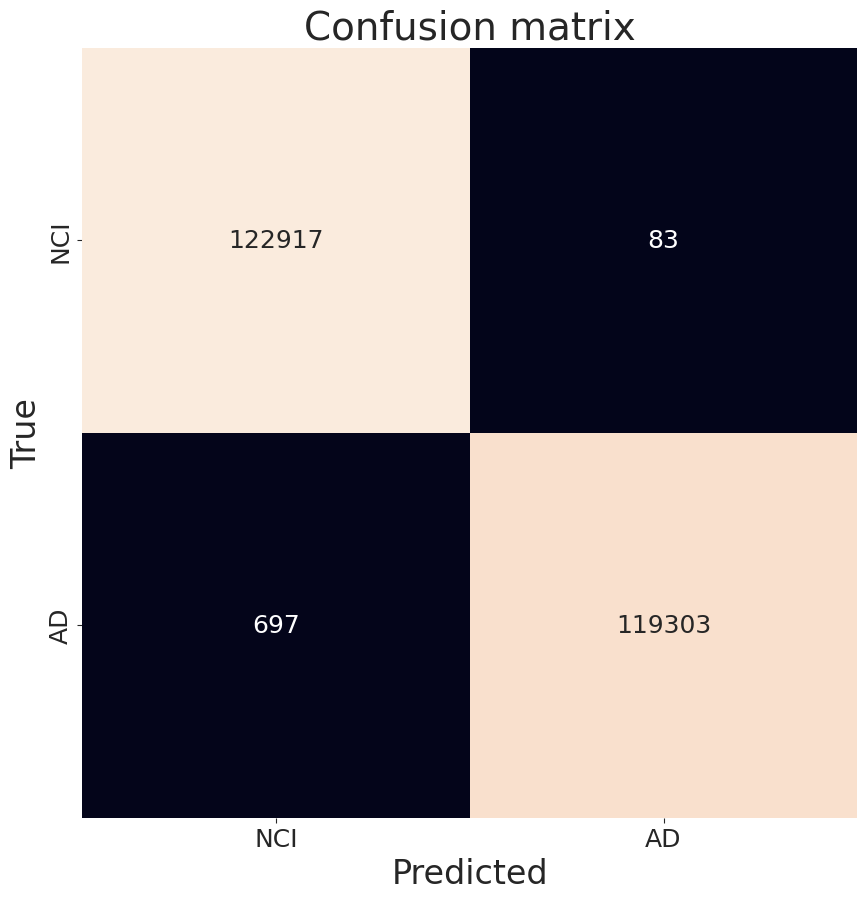

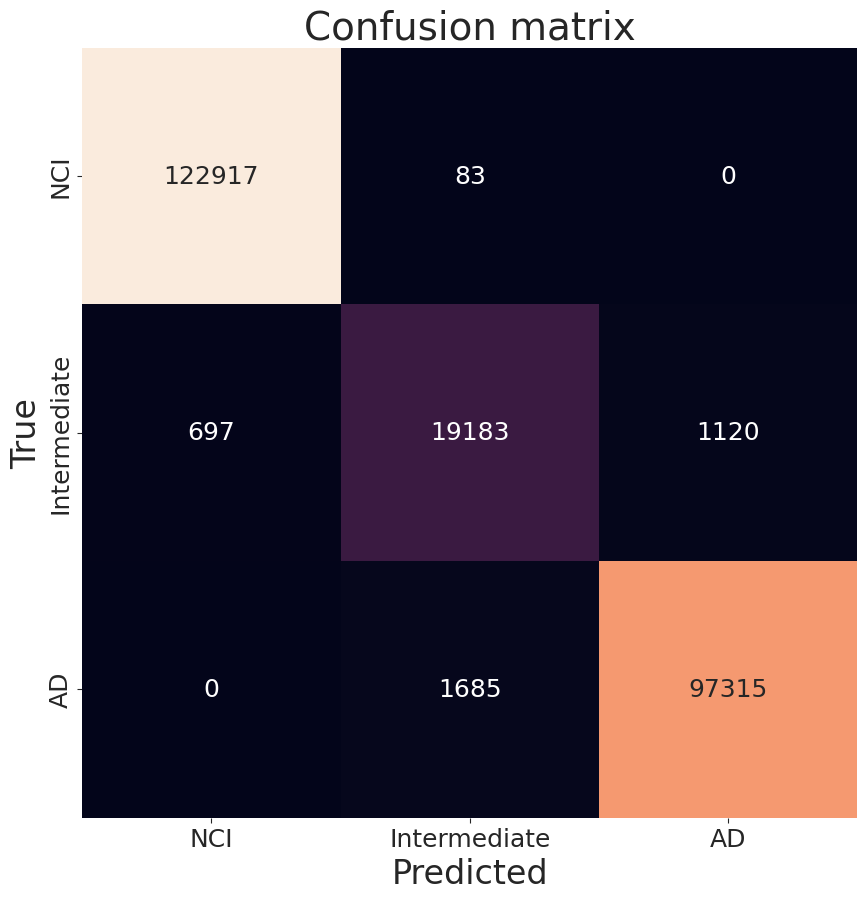

------------------25 % uncertainty-------------------


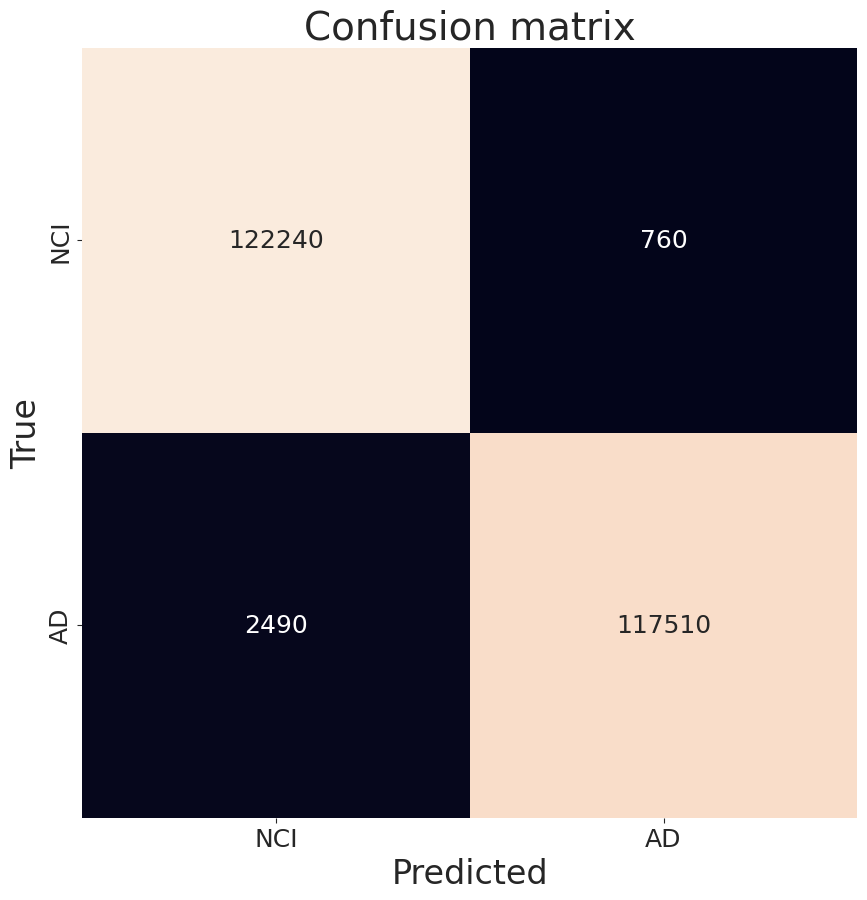

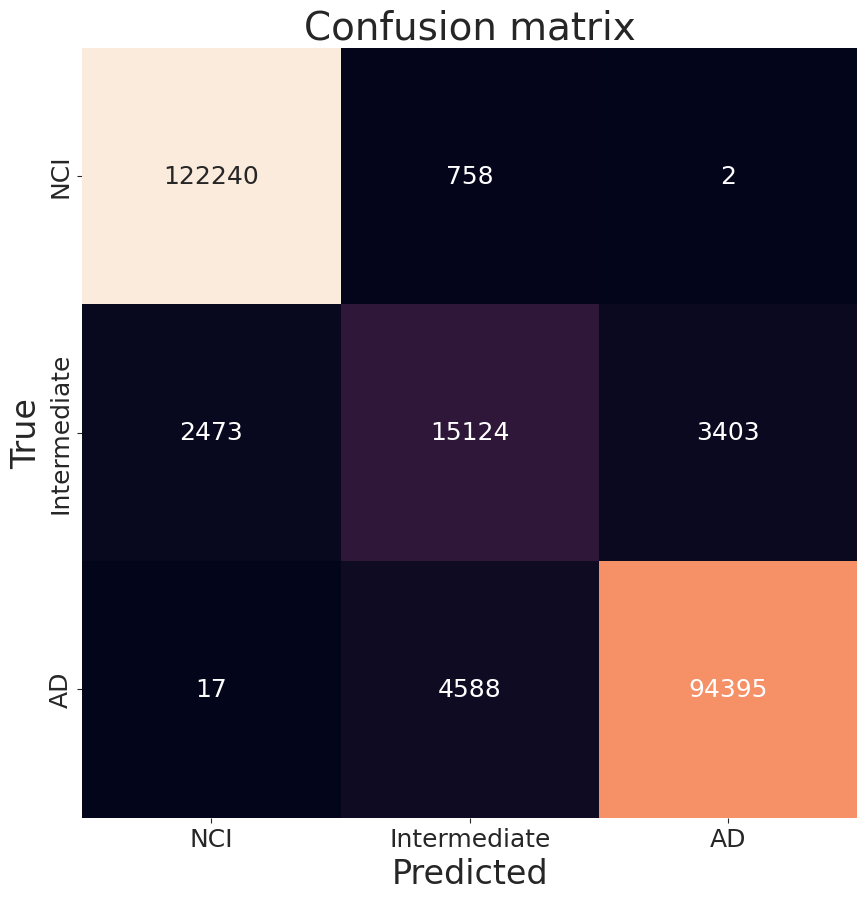

------------------50 % uncertainty-------------------


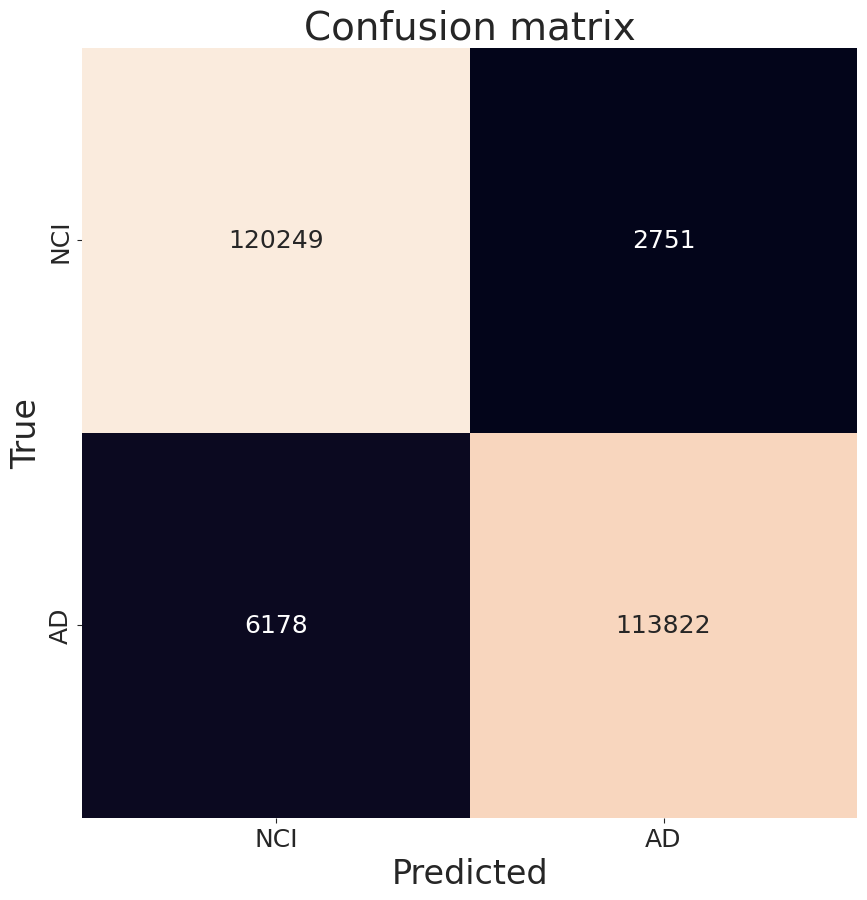

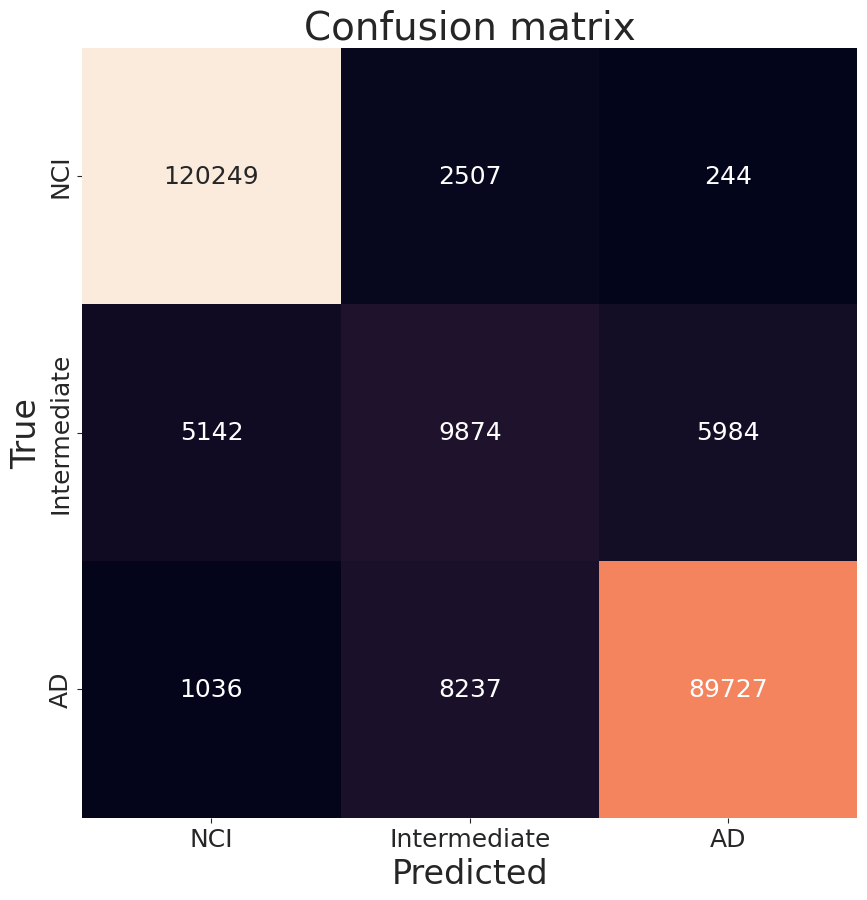

In [60]:
for uncertainty in uncertainties:
    single_thres_cnf_mats[uncertainty] = confusion_matrix(single_thres_gt_arrs[uncertainty], single_thres_pred_arrs[uncertainty])
    dual_thres_cnf_mats[uncertainty] = confusion_matrix(dual_thres_gt_arrs[uncertainty], dual_thres_pred_arrs[uncertainty])
    print(f"------------------{uncertainty} % uncertainty-------------------")
    plot_confusion_matrix(single_thres_cnf_mats[uncertainty], ["NCI", "AD"])
    plot_confusion_matrix(dual_thres_cnf_mats[uncertainty], ["NCI", "Intermediate", "AD"])

------------------10 % uncertainty-------------------


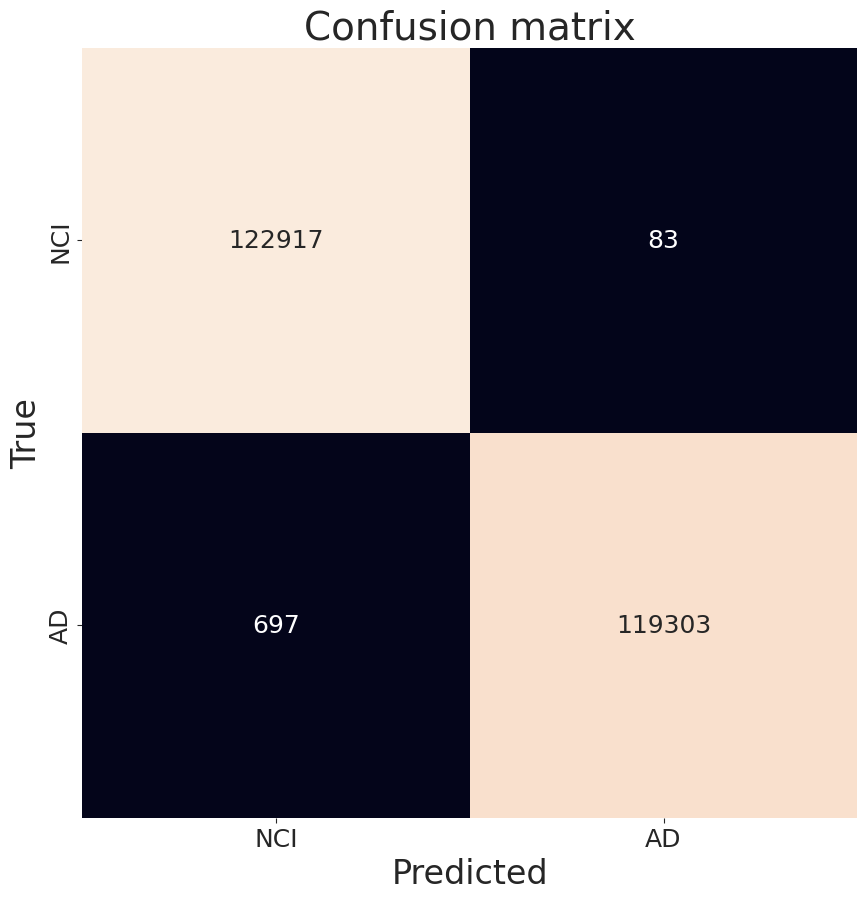

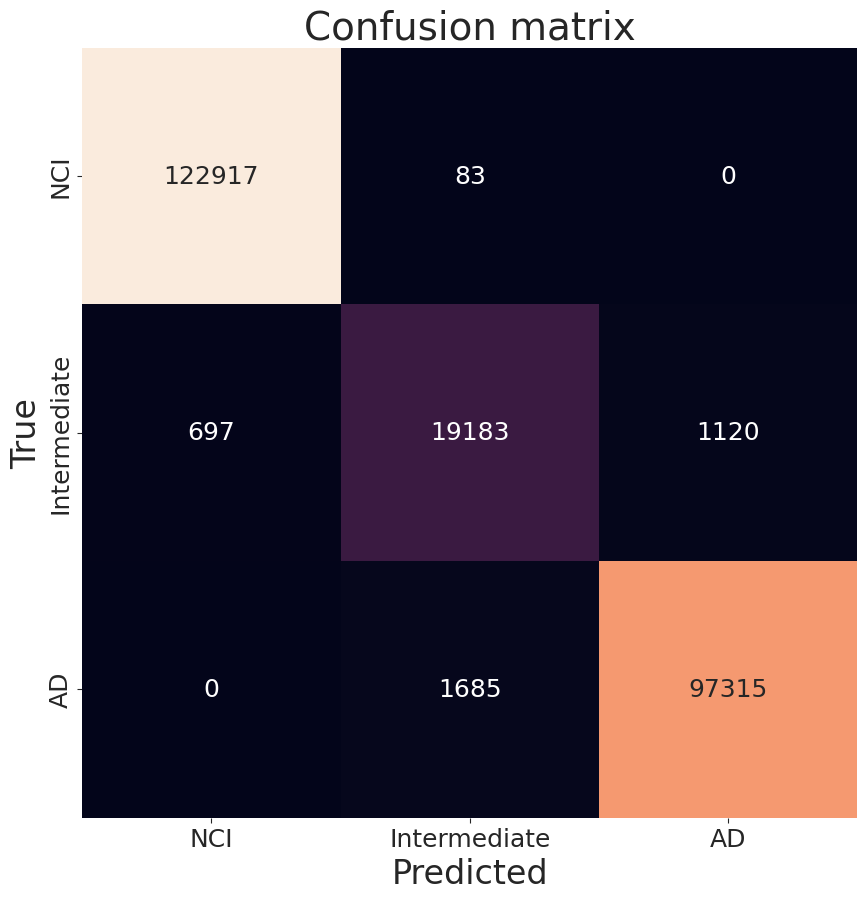

------------------25 % uncertainty-------------------


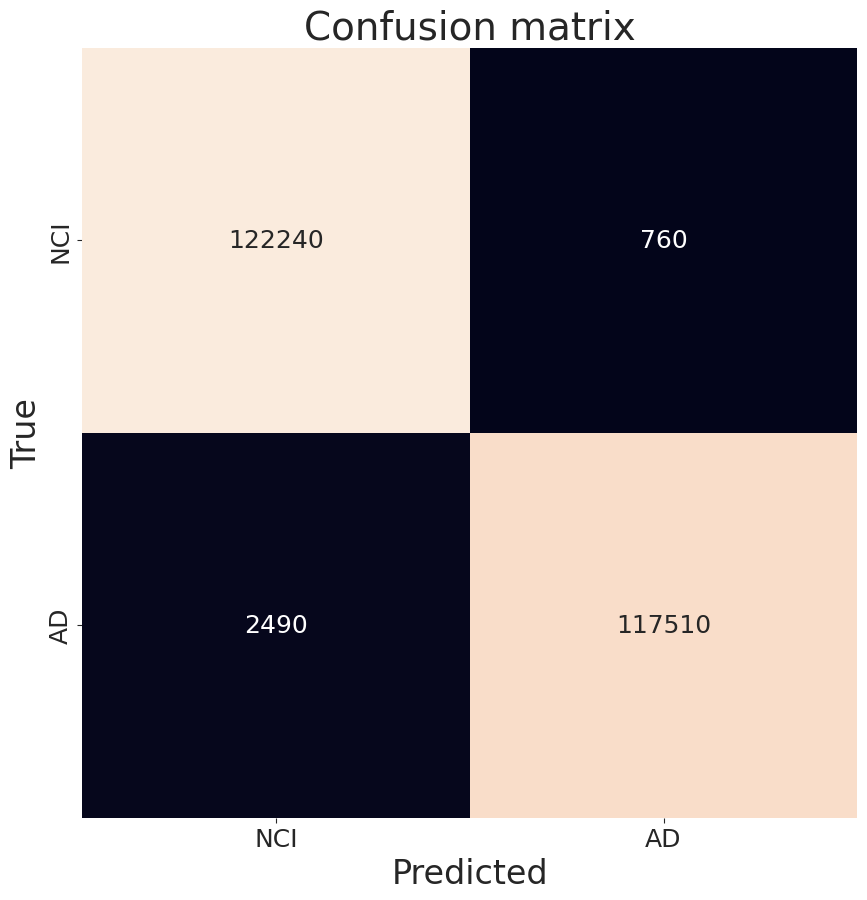

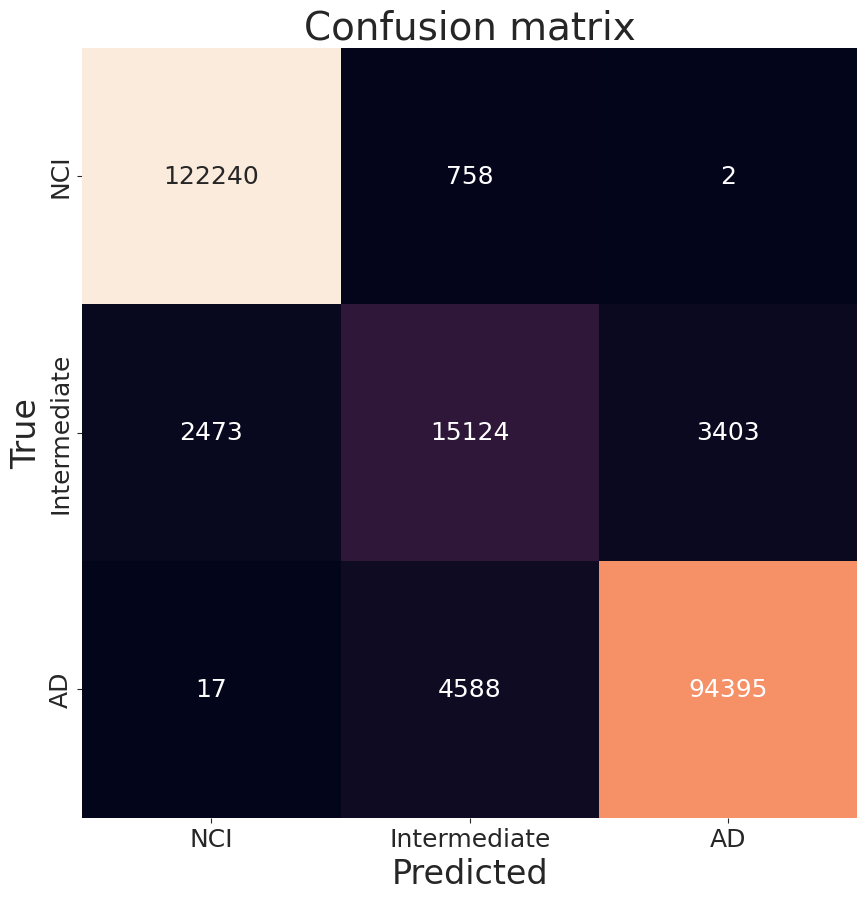

------------------50 % uncertainty-------------------


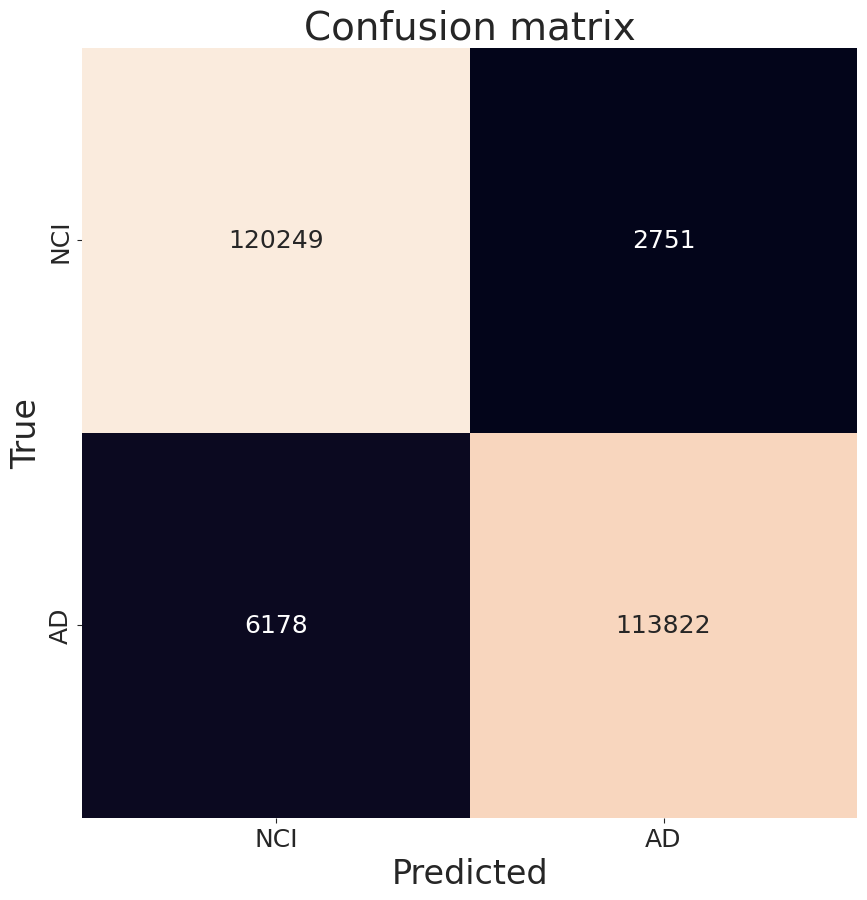

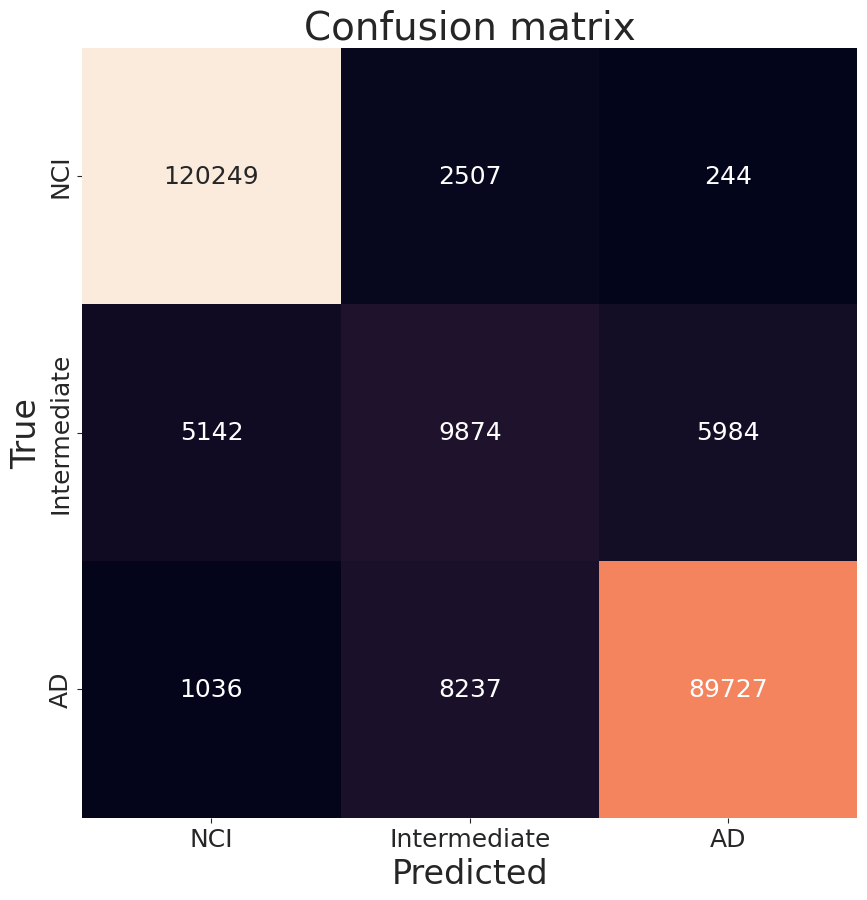

In [61]:
for uncertainty in uncertainties:
    single_thres_cnf_mats[uncertainty] = confusion_matrix(single_thres_gt_arrs[uncertainty], single_thres_pred_arrs[uncertainty])
    dual_thres_cnf_mats[uncertainty] = confusion_matrix(dual_thres_gt_arrs[uncertainty], dual_thres_pred_arrs[uncertainty])
    print(f"------------------{uncertainty} % uncertainty-------------------")
    plot_confusion_matrix(single_thres_cnf_mats[uncertainty], ["NCI", "AD"])
    plot_confusion_matrix(dual_thres_cnf_mats[uncertainty], ["NCI", "Intermediate", "AD"])

In [62]:
for uncertainty in uncertainties:
    print(f"------------------{uncertainty} % uncertainty-------------------")
    print("Single threshold:")
    display_differential_classification_results_one_threshold(
                ad_diff_cls=single_thres_expt_results.loc[uncertainty, "AD"],
                nci_diff_cls=single_thres_expt_results.loc[uncertainty, "NCI"], 
                num_patients=num_patients)
    print("Dual threshold:")
    display_differential_classification_results_two_thresholds(
                ad_diff_cls=dual_thres_expt_results.loc[uncertainty, "AD"], 
                int_diff_cls=dual_thres_expt_results.loc[uncertainty, "Intermediate"], 
                nci_diff_cls=dual_thres_expt_results.loc[uncertainty, "NCI"], 
                num_patients=num_patients)

------------------10 % uncertainty-------------------
Single threshold:
0.00 % simulated subjects were differentially classified from the Alzheimer's disease category.
1.23 % simulated subjects were differentially classified from the NCI category.
1.23 % simulated subjects were differentially classified between AD and NCI categories.
Total number of differentially classified individuals: 3
Dual threshold:
2.88 % simulated subjects were differentially classified from the Alzheimer's disease category.
2.88 % simulated subjects were differentially classified from the intermediate category.
0.00 % simulated subjects were differentially classified from the NCI category.
Fraction of simulated subjects differentially classified: Approximately 5.76%
Total number of differentially classified individuals: 14
------------------25 % uncertainty-------------------
Single threshold:
1.65 % simulated subjects were differentially classified from the Alzheimer's disease category.
3.70 % simulated subje

In [63]:
def visualize_differential_classification_results(results: pd.DataFrame) -> None:
    width = 0.3
    plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots()
    for i, uncertainty in enumerate(results.index):
        ax.bar(np.arange(results.shape[1])+i*width, results.loc[uncertainty, :], width, label=f"{uncertainty}% uncertainty")
    plt.xlabel("Category")
    plt.ylabel("Number of individuals differentially classified")
    plt.title(f"Effect of simulated uncertainty on differential classification")
    plt.xticks(np.arange(results.shape[1])+width*results.shape[1]/2, results.columns)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot()

<Figure size 800x600 with 0 Axes>

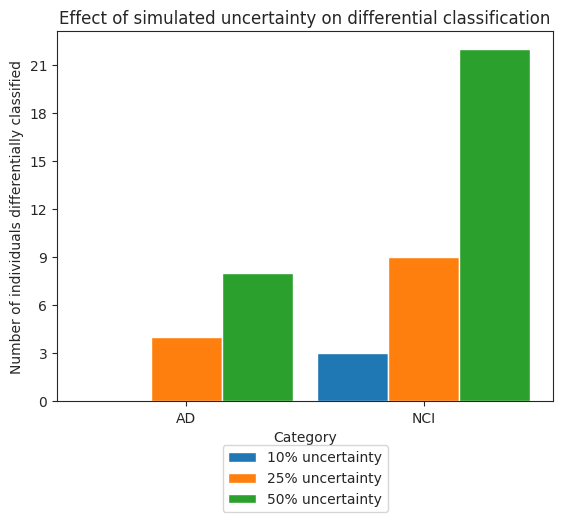

In [64]:
visualize_differential_classification_results(single_thres_expt_results)

- Plot SD of scores for each subject
- Upset plot -> compare two different analyses
- Additional analyses:
    - log2 + 1/log10 + 1 transform
    - filtering
    - compare tails, outliers etc for AD and NCI for distributions
    - (scipy does internally a log transform!)
        - Pick a gene
        - Sample from the distribution, plot points in histogram (gamma, gaussian, lognormal)
        - Metrics: medians, skewness/kurtosis
- Change dual thresholds to 90% (AD/NCI)

<Figure size 800x600 with 0 Axes>

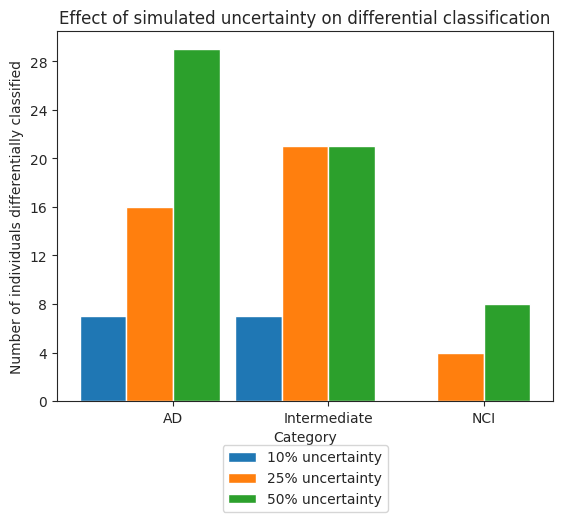

In [65]:
visualize_differential_classification_results(dual_thres_expt_results)

- Every gene changing by 50% does not represent actuality.

#### Subject-wise agreement between Simulated scores and Ground truth

In [66]:
single_thres_subj_wise_agreement = calculate_subject_wise_agreement(gt_arr_dict=single_thres_gt_arrs, pred_arr_dict=single_thres_pred_arrs, uncertainties=uncertainties)
dual_thres_subj_wise_agreement = calculate_subject_wise_agreement(gt_arr_dict=dual_thres_gt_arrs, pred_arr_dict=dual_thres_pred_arrs, uncertainties=uncertainties)

In [67]:
categories = ["NCI", "Intermediate", "AD"]
gt_arr_dict, pred_arr_dict = dual_thres_gt_arrs, dual_thres_pred_arrs

In [68]:
dual_thres_subj_wise_disagreement = calculate_subject_wise_disagreement(gt_arr_dict=dual_thres_gt_arrs, pred_arr_dict=dual_thres_pred_arrs, uncertainties=uncertainties, categories=["NCI", "Intermediate", "AD"])

In [69]:
dual_thres_subj_wise_disagreement.to_csv("dual_thres_subj_wise_disagreement.csv")

In [70]:
gt_probs = antilogit_classifier_score(np.sum(coefficients[:, np.newaxis] * z_scores_df, axis=0))

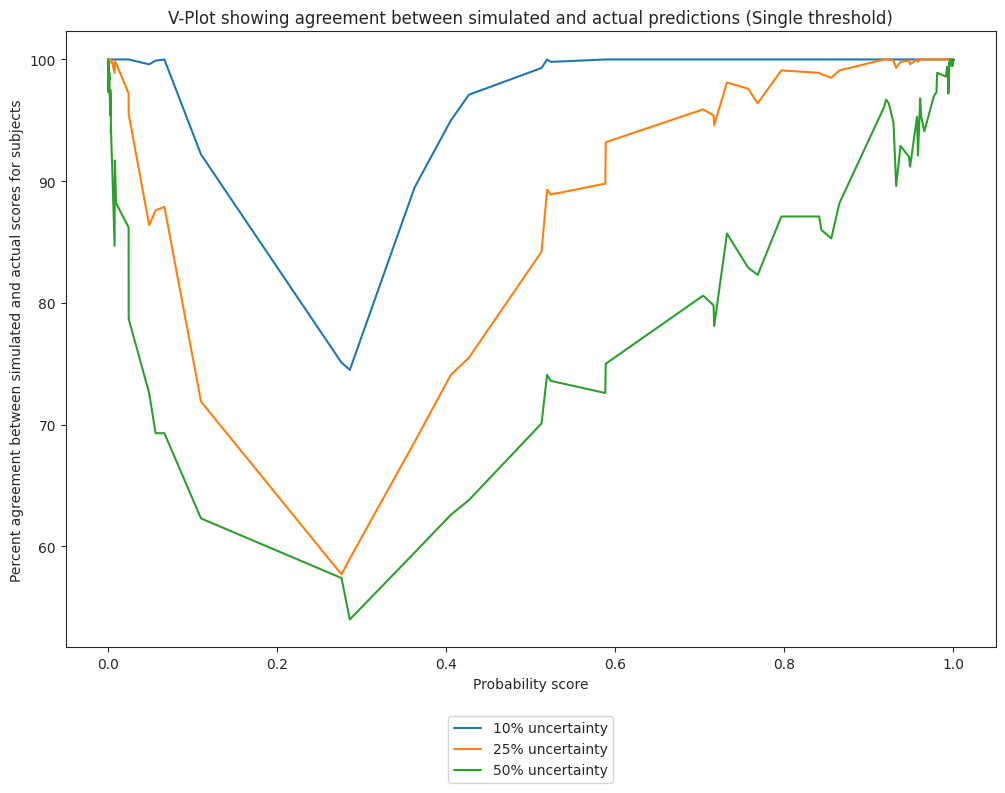

In [72]:
_temp = single_thres_subj_wise_agreement.iloc[gt_probs.argsort(), :]
plt.figure(figsize=(12, 8))
for uncert in uncertainties:
    plt.plot(np.sort(gt_probs), _temp[f"{uncert}% uncertainty"], label=f"{uncert}% uncertainty")
plt.title("V-Plot showing agreement between simulated and actual predictions (Single threshold)")
plt.xlabel("Probability score")
plt.ylabel("Percent agreement between simulated and actual scores for subjects")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.show()

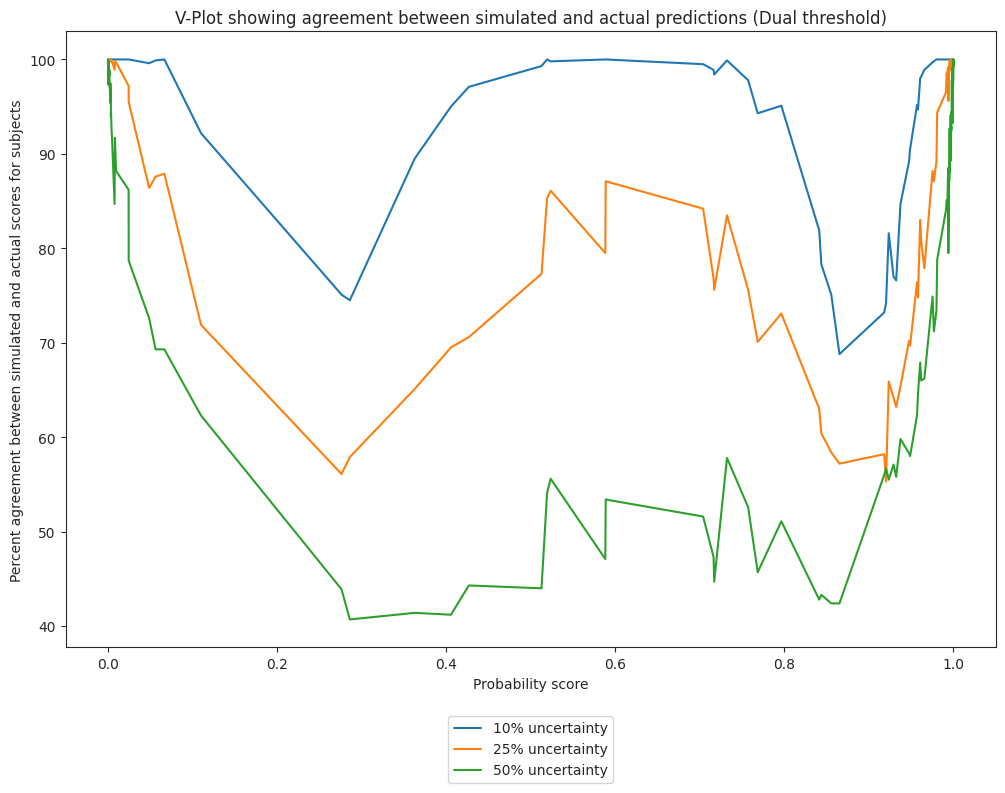

In [73]:
_temp = dual_thres_subj_wise_agreement.iloc[gt_probs.argsort(), :]
plt.figure(figsize=(12, 8))
for uncert in uncertainties:
    plt.plot(np.sort(gt_probs), _temp[f"{uncert}% uncertainty"], label=f"{uncert}% uncertainty")
plt.title("V-Plot showing agreement between simulated and actual predictions (Dual threshold)")
plt.xlabel("Probability score")
plt.ylabel("Percent agreement between simulated and actual scores for subjects")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.show()

[]

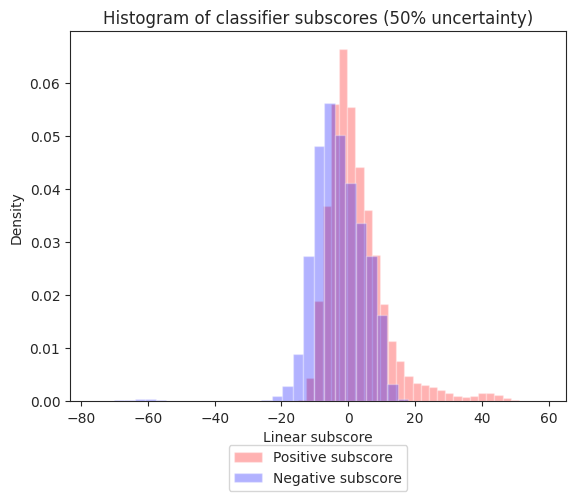

In [74]:
plt.hist(pos_subscore_arrs[uncert], 30, density=True, color='red', alpha=0.3, label="Positive subscore")
plt.hist(neg_subscore_arrs[uncert], 30, density=True, color='blue', alpha=0.3, label="Negative subscore")
plt.xlabel("Linear subscore")
plt.ylabel("Density")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.title(f"Histogram of classifier subscores ({uncert}% uncertainty)")
plt.plot()

In [75]:
num_interm = ((thres_1 <= gt_probs) & (gt_probs < thres_2)).sum()

In [76]:
num_interm / num_patients * 100

np.float64(7.818930041152264)

In [77]:
num_interm

np.int64(19)